### Visualization Performance


In [16]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import itertools
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
import glob
import warnings
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from utility.utility import *
from utility.techIndex import talib_index
from utility.model import dnn, lstm, conv1d, conv2d, transformer

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [17]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [18]:
# get last weight
newest = False

test_weight = {
    'transformer': '20220922-003626_e500_s30.h5',
    'conv1d': '20220922-010800_e500_s30.h5',
    'conv2d': '20220922-010843_e500_s30.h5',
    # 'dnn': '202209112327_dataset_2015_2019_dnn-ep002',
    'lstm': '20220922-011359_e500_s30.h5'
 }
# test data
stock = 'TWII_test.csv'

if newest:
    for model in test_weight.keys():
        target_weight_list = [x.replace('.h5','') for x in glob.glob(os.path.join('weights',model,'*.h5')) if stock in x]
        test_weight[model] = target_weight_list[-1].split('\\')[2]

# window length
# slide = 30

df = read_data(config, 'test')
model_metric = {}
test_weight

data\TWII_2020_2021.csv


{'transformer': '20220922-003626_e500_s30.h5',
 'conv1d': '20220922-010800_e500_s30.h5',
 'conv2d': '20220922-010843_e500_s30.h5',
 'lstm': '20220922-011359_e500_s30.h5'}

### Predict Price

1 g
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 30, 12)]     0           []                               
                                                                                                  
 time2_vector_20 (Time2Vector)  (None, 30, 2)        120         ['input_21[0][0]']               
                                                                                                  
 concatenate_20 (Concatenate)   (None, 30, 14)       0           ['input_21[0][0]',               
                                                                  'time2_vector_20[0][0]']        
                                                                                                  
 transformer_encoder_60 (Transf  (None, 30, 14)      188756      ['concatenate_20[0][0]

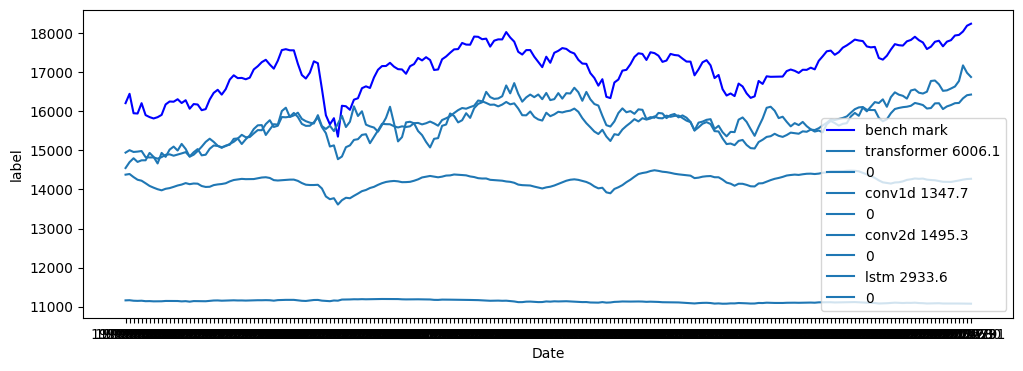

CPU times: total: 17.7 s
Wall time: 18.5 s


In [42]:
%%time

X, y = label(df)
X_dim = X.index
X_scaler, y_scaler = scaler(X, y, config, 'test')
X_scaler, y_scaler = training_window(X_scaler, y_scaler , config)
# sns.set_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
colors = "bgrcmykw"
color_index = 0
sns.lineplot(data = y[int(config['MODEL']['slide']):], ax=ax, color=colors[color_index], label=f'bench mark')

for model_name, weight in test_weight.items(): 
    color_index+=1
    # print(color_index,colors[color_index])
    model = load_model(X_scaler.shape, model_name)
    model.load_weights(f'model/{model_name}/{config["MODEL_WEIGHTS"][model_name]}')
    y_pred = model.predict(X_scaler)
    y_inverse = inverse_predict(y_pred, config)
    mse = mean_squared_error(y[int(config['MODEL']['slide']):], y_inverse, squared=False)   
    sns.lineplot(data = y_inverse, ax=ax, color=colors[color_index], label=f'{model_name} {round(mse,1)}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
plt.show()


In [ ]:

def plot_all_model(stock_name, model_metric, env):
    print(stock_name,'data')
    """combined plots of plot_portfolio_transaction_history and plot_portfolio_performance_comparison"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    dates, buy_and_hold_portfolio_values, buy_and_hold_return = buy_and_hold_benchmark(stock_name, env.init_invest, env.n_stock)
    ax.set_title(f'Model vs. Buy and Hold Performance')
    dates = [datetime.strptime(d, '%Y%m%d').date() for d in dates]
    ###
    dates = dates[:-1]
    buy_and_hold_portfolio_values = buy_and_hold_portfolio_values[:-1]
    # print(f'dates:     {len(dates)} \ndaily value:{len(daily_portfolio_value)}\nBH value:{len(buy_and_hold_portfolio_values)}')
    ax.plot(dates, buy_and_hold_portfolio_values, label=f'Buy and Hold Return: ${buy_and_hold_return:.2f}')
    ###
    for model, portfolio in model_metric.items():
        agent_return = portfolio[-1] - env.init_invest
        ax.plot(dates, portfolio, label=f'{model.upper()} Return: ${agent_return:.2f}')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))
    # plt.xticks(pd.date_range('2018-1-02', '2019-08-22', freq='1m'))
    plt.xticks(pd.date_range(dates[0],dates[-1],freq='1m'))
    ax.legend()
    plt.gcf().autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# plot_all_model(stock_name, model_metric, env)    